# Data Validation of Downtown Bluetooth Readings

## Directional Mismatch
Replication of @radumas earlier analysis of directional mismatch on the Gardiner. 

Notes: BT sensor at King/Spadina was down during Oct.17 to Oct.31 resulting in missing data for that intersection.
### Questions to Answer
 - Is detection biased in any direction?
 - Is there a detection rate difference between E/W vs N/S?

In [55]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd
import pandas.io.sql as pandasql
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [3]:
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional')
direction_obs = pandasql.read_sql(sql, con)

NOTE: Oneway streets are ommitted from the `ryu4.aggr_bt_directional` table. Values produced by the chart are from the entirety of September and October

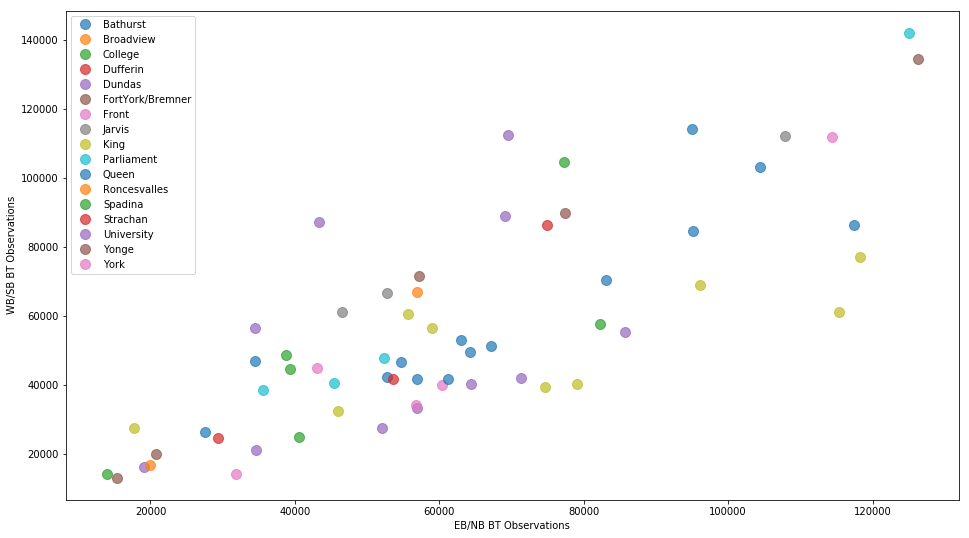

In [5]:
groups = direction_obs.groupby('street')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (street, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=street, linestyle='')
plt.legend()

The scatterplot shows WB/SB observations of a route compared to their repsective EB/NB BT observations. As you can see, a few of the routes aren't 1:1.

In [9]:
sql = '''SELECT d.sb_wb_report_name AS "WB/SB Route Name", \
        d.nb_eb_report_name AS "EB/NB Route Name", \
        d.eb_nb_obs AS "Number EB/NB obs", \
        d.wb_sb_obs AS "Number WB/SB obs", \
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN d.eb_nb_obs / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN d.wb_sb_obs / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "EB/WB NB/SB Ratio", \
        rp.direction "Direction"
        FROM ryu4.aggr_bt_directional d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        ORDER BY "EB/WB NB/SB Ratio" DESC;'''
print_table(sql, con)

The chart above shows each route's EB/NB and WB/SB observation counts for Sept-Oct in addition to EB/NB-WB/SB observations. All route observations are not 1:1 with both directions which is expected. However, these differences are fairly high for both directions and there are many factors which may be influencing them. Lowering the range and taking data that is more recent may produce better results.

In [16]:
# select one week of data between '2017-10-25 00:00:00' and '2017-11-01 00:00:00'
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional_oneweek')
direction_obs_oneweek = pandasql.read_sql(sql, con)

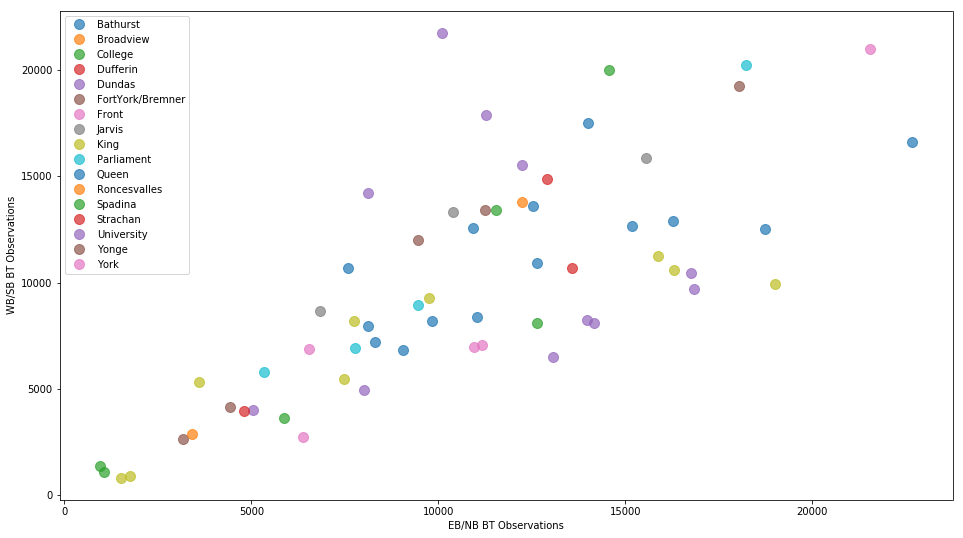

In [18]:
groups = direction_obs_oneweek.groupby('street')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (street, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=street, linestyle='')
plt.legend()

Not much has changed between the 2-month interval graph and the 1-week interval graph. Since not much has changed, a focus is given on the top/bottom routes with largest difference between EB/NB and WB/SB.

In [33]:
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN d.eb_nb_obs / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN d.wb_sb_obs / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'EBWB'
        ORDER BY "ratio" DESC;'''
ebwb_obs = pandasql.read_sql(sql, con)
sql = '''SELECT 
        CASE
            WHEN d.eb_nb_obs > d.wb_sb_obs THEN d.eb_nb_obs / (d.eb_nb_obs + d.wb_sb_obs)
            WHEN d.eb_nb_obs < d.wb_sb_obs THEN d.wb_sb_obs / (d.eb_nb_obs + d.wb_sb_obs)
        END AS "ratio"
        FROM ryu4.aggr_bt_directional_oneweek d
        INNER JOIN ryu4.bt_route_pairs rp ON rp.nb_eb_report_name = d.nb_eb_report_name 
        WHERE rp.direction = 'NBSB'
        ORDER BY "ratio" DESC;'''
nbsb_obs = pandasql.read_sql(sql, con)

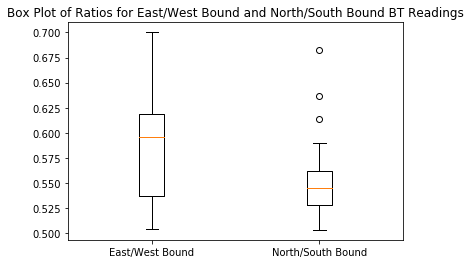

In [35]:
data = [ebwb_obs, nbsb_obs]
plt.figure()
plt.boxplot(data)
plt.xticks([1,2],['East/West Bound', 'North/South Bound'])
plt.title("Box Plot of Ratios for East/West Bound and North/South Bound BT Readings")
plt.show()

As shown by the plot, the magnitude and number of imbalanced E/W bound observations is greater than N/S bound readings. More than 50% of E/W bound observations are greater than the 50th percentile of N/S bound observations.
The outliers for N/S bound are:

- University - Queen to Dundas
- University - Dundas to College
- University - King to Queen

Considering this box plot, it can be assumed that readers in the East/West bound direction have a detection rate difference against one direction.

In [28]:
sql = '''SELECT sb_wb_report_name AS "wbsb_route", \
        nb_eb_report_name AS "ebnb_route" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY eb_nb_obs - wb_sb_obs;'''
routes = pandasql.read_sql(sql, con)
ebnb_route = routes.ebnb_route
wbsb_route = routes.wbsb_route

Day of Week Plots for BT Observations


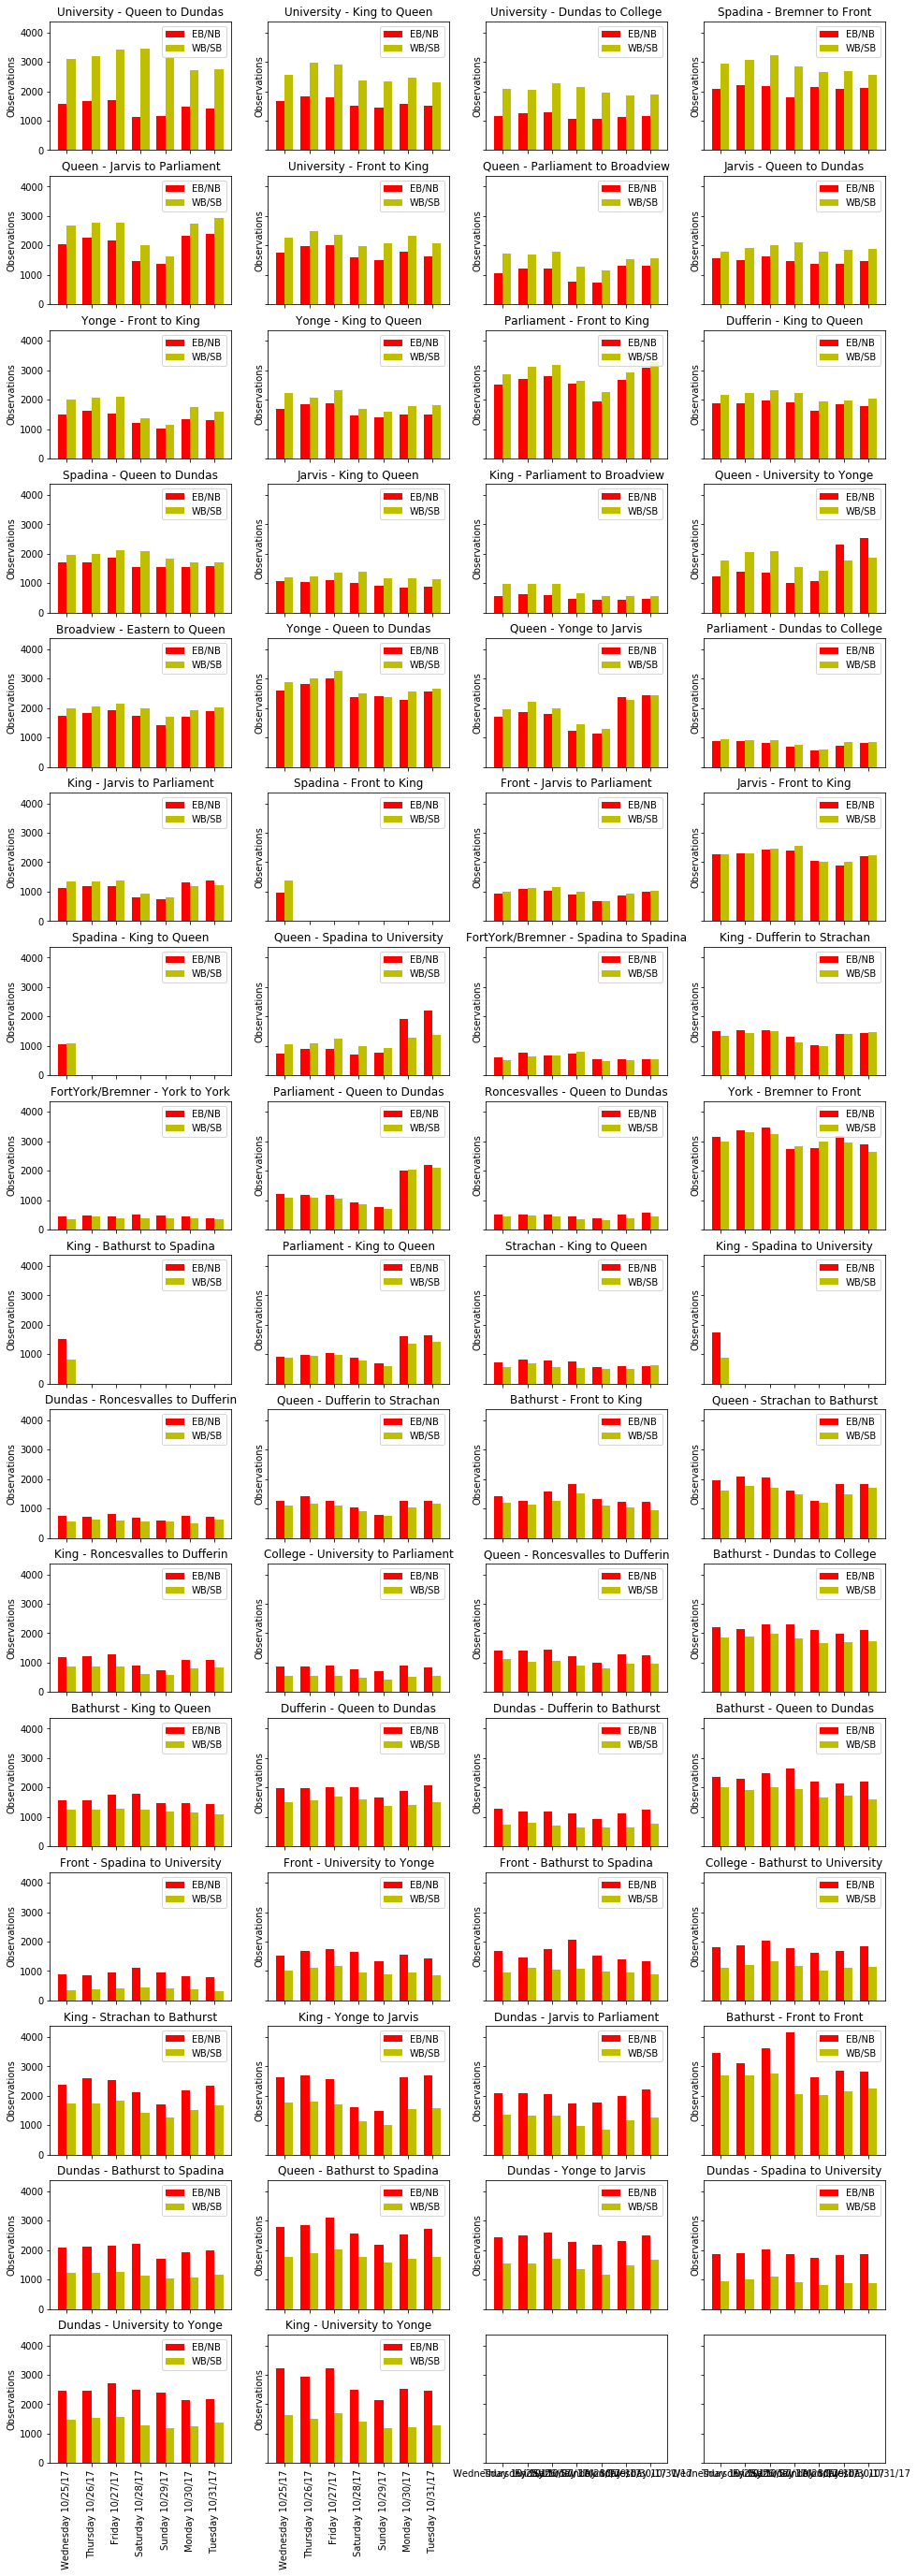

In [29]:
fig, ax = plt.subplots(nrows=16, ncols=4, sharex= True, sharey= True, figsize=(16,48))
row, col = 0, 0 
for i in range(len(routes)):
    sql = pg.SQL('''SELECT eb_nb_obs, wb_sb_obs, date_bin, street, from_street, to_street \
            FROM ryu4.aggr_bt_directional_day \
            WHERE nb_eb_report_name = {ebnb_route} AND sb_wb_report_name = {wbsb_route}
            ORDER BY date_bin''').format(ebnb_route = pg.Literal(ebnb_route[i]), wbsb_route = pg.Literal(wbsb_route[i]))
    route_obs_day = pandasql.read_sql(sql, con)
    
    N = len(route_obs_day)
    ind = np.arange(N)
    width = 0.35
    ebnb_rects = ax[row,col].bar(ind, route_obs_day.eb_nb_obs, width, color='r')
    wbsb_rects = ax[row,col].bar(ind + width, route_obs_day.wb_sb_obs, width, color='y')
    ax[row,col].set_ylabel('Observations')
    ax[row,col].set_title(route_obs_day.street[0] + ' - ' + 
                          route_obs_day.from_street[0] + ' to ' +
                          route_obs_day.to_street[0])
    ax[row,col].set_xticks(ind + width / 2)
    ax[row,col].set_xticklabels([date.strftime("%A %x") for date in route_obs_day.date_bin], rotation=90)
    ax[row,col].legend((ebnb_rects[0], wbsb_rects[0]), ('EB/NB', 'WB/SB'))
    col += 1
    if col%4 == 0: 
        row += 1
        col  = 0
print('Day of Week Plots for BT Observations')
plt.show()

In [41]:
sql = '''SELECT sb_wb_report_name AS "wbsb_route", \
        nb_eb_report_name AS "ebnb_route" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY CASE
            WHEN eb_nb_obs > wb_sb_obs THEN eb_nb_obs / (eb_nb_obs + wb_sb_obs)
            WHEN eb_nb_obs < wb_sb_obs THEN wb_sb_obs / (eb_nb_obs + wb_sb_obs)
        END DESC;'''
routes = pandasql.read_sql(sql, con)
ebnb_route = routes.ebnb_route
wbsb_route = routes.wbsb_route

DT-0071. Front-EB_Spadina-to-University / DT-0077. Front-WB_University-to-Spadina


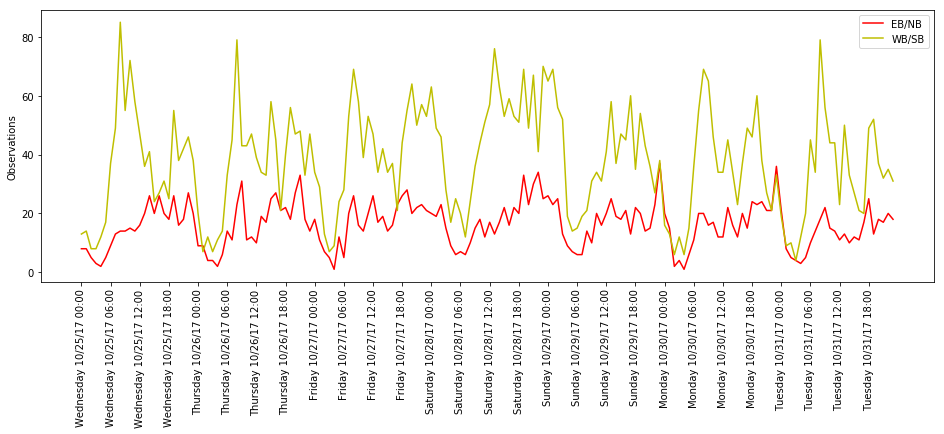

DT-0117. University-NB_Queen-to-Dundas / DT-0110. University-SB_Dundas-to-Queen


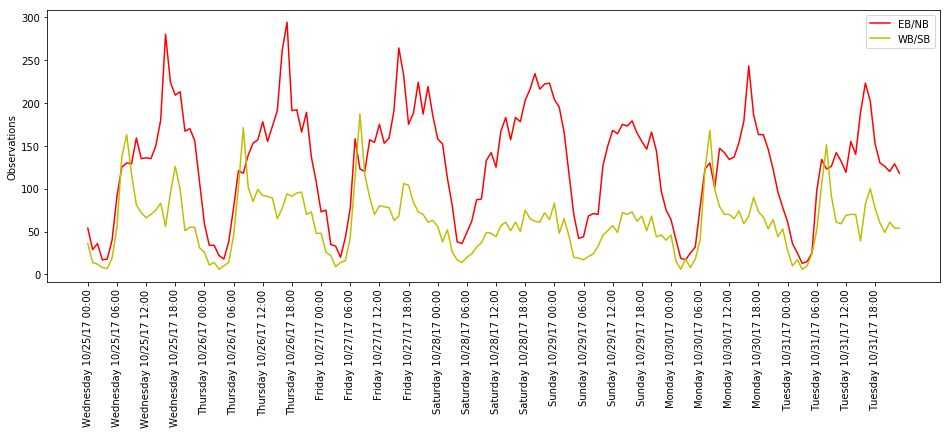

DT-0008. Dundas-EB_Spadina-to-University / DT-0015. Dundas-WB_University-to-Spadina


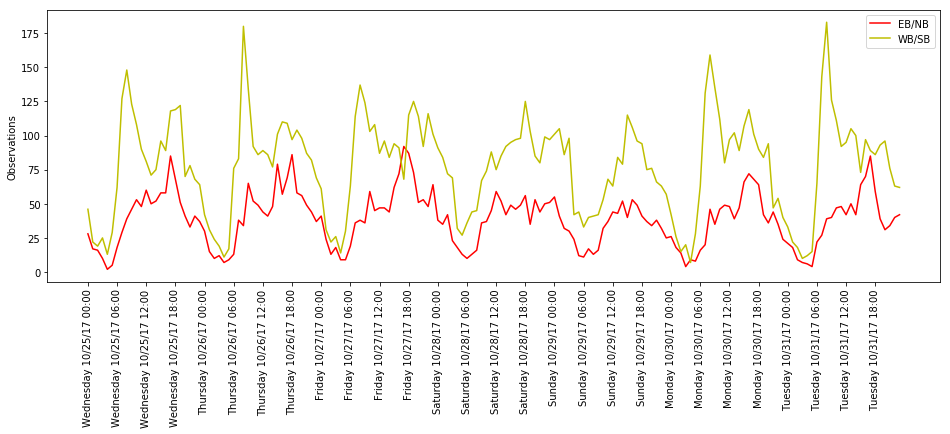

DT-0053. King-EB_Spadina-to-University / DT-0062. King-WB_University-to-Spadina


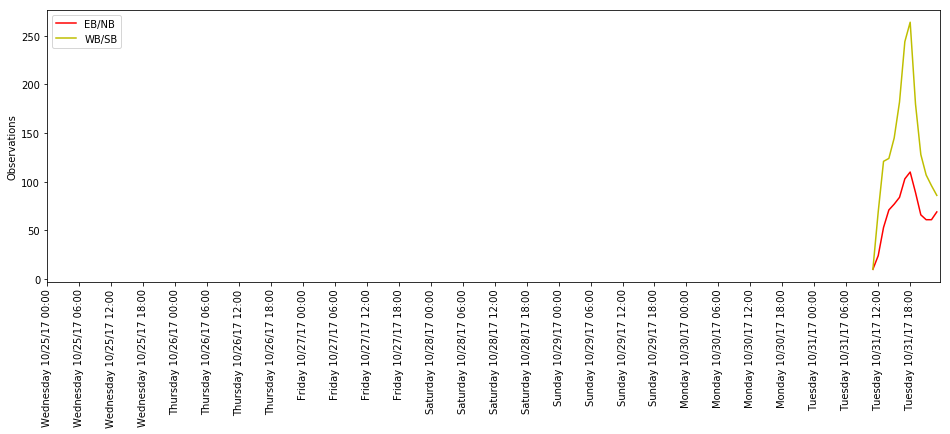

DT-0054. King-EB_University-to-Yonge / DT-0061. King-WB_Yonge-to-University


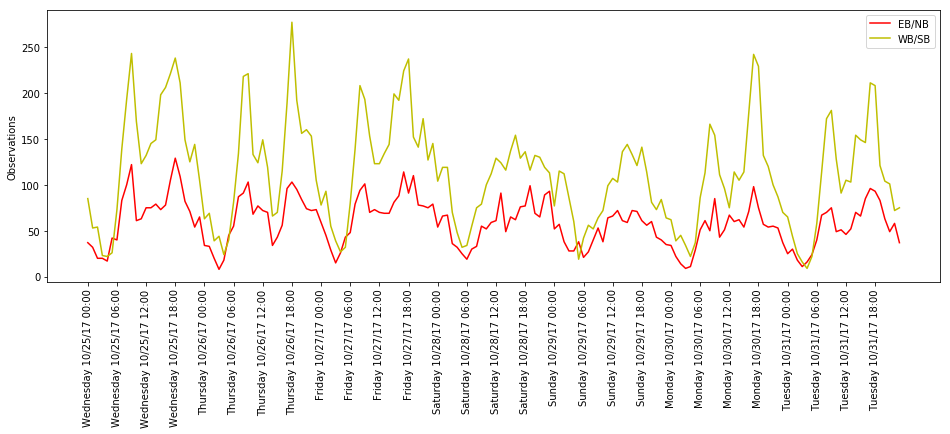

DT-0052. King-EB_Bathurst-to-Spadina / DT-0063. King-WB_Spadina-to-Bathurst


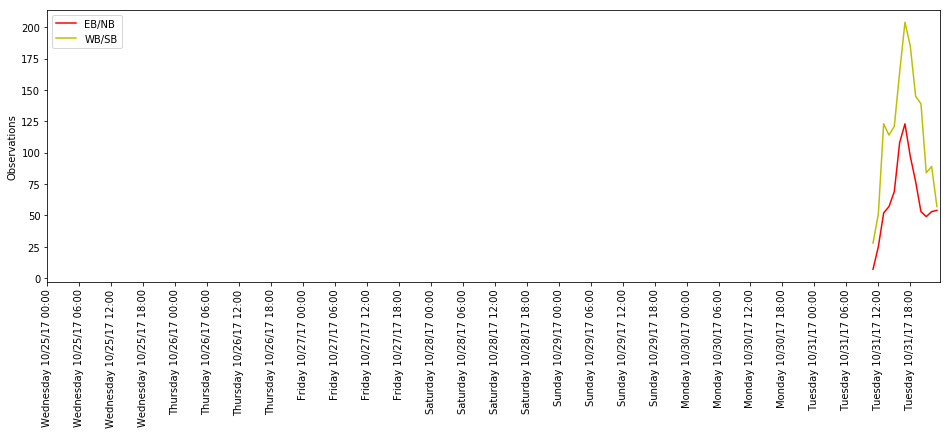

DT-0007. Dundas-EB_Bathurst-to-Spadina / DT-0016. Dundas-WB_Spadina-to-Bathurst


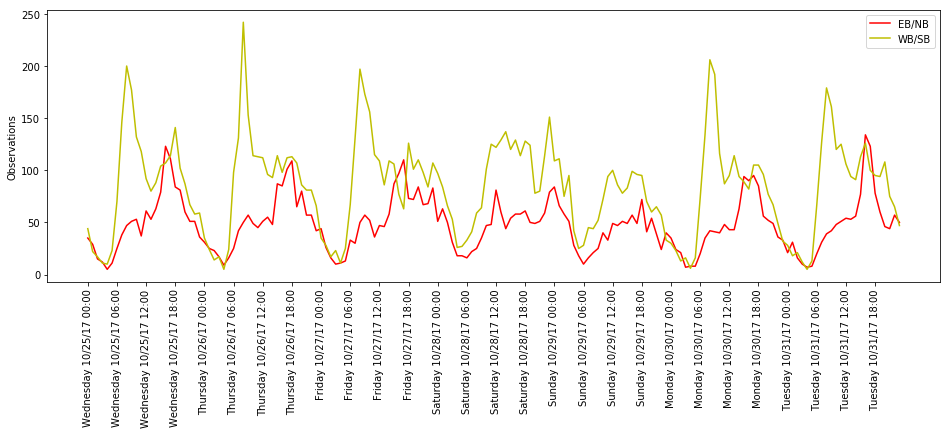

DT-0118. University-NB_Dundas-to-College / DT-0109. University-SB_College-to-Dundas


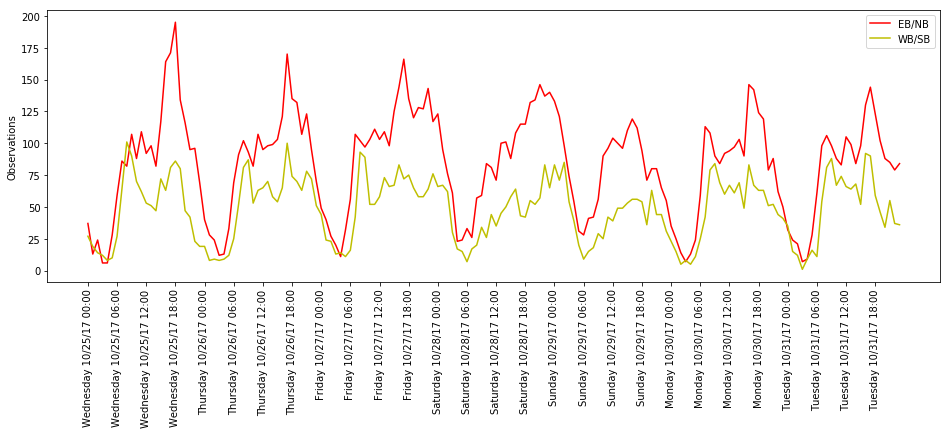

DT-0009. Dundas-EB_University-to-Yonge / DT-0014. Dundas-WB_Yonge-to-University


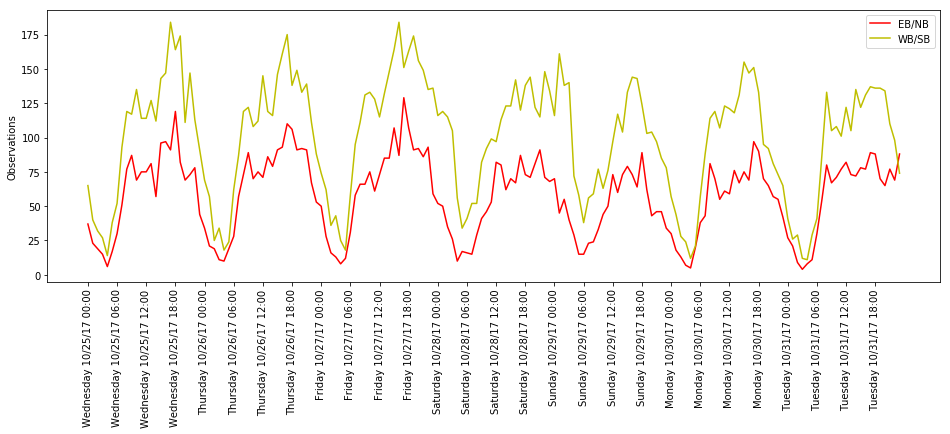

DT-0011. Dundas-EB_Jarvis-to-Parliament / DT-0012. Dundas-WB_Parliament-to-Jarvis


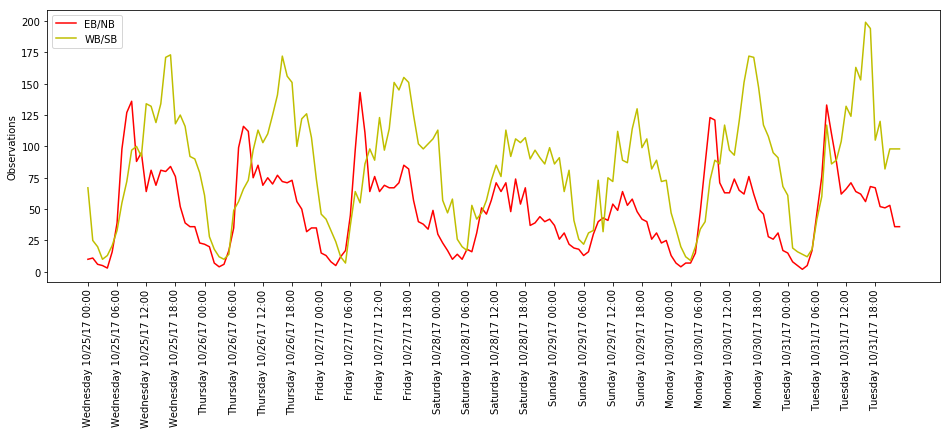

DT-0006. Dundas-EB_Dufferin-to-Bathurst / DT-0017. Dundas-WB_Bathurst-to-Dufferin


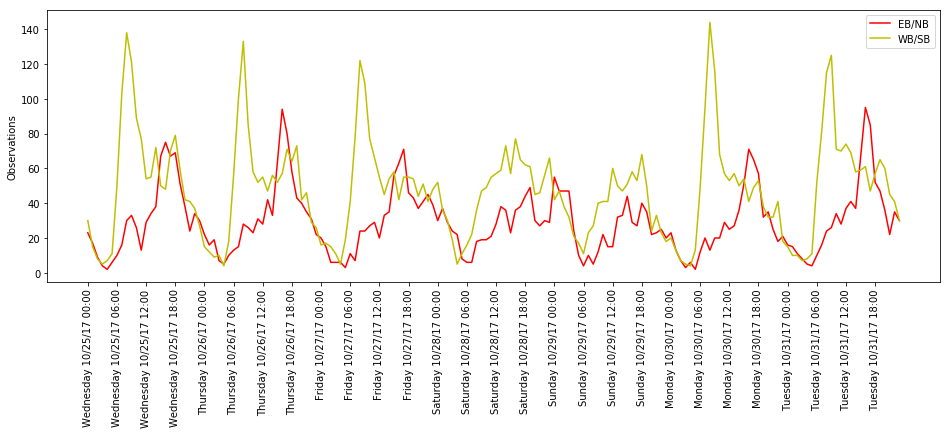

DT-0002. College-EB_University-to-Parliament / DT-0003. College-WB_Parliament-to-University


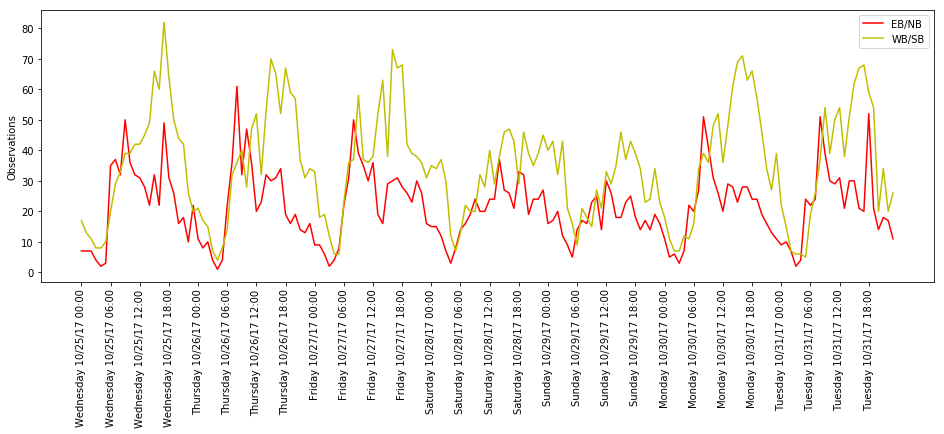

DT-0010. Dundas-EB_Yonge-to-Jarvis / DT-0013. Dundas-WB_Jarvis-to-Yonge


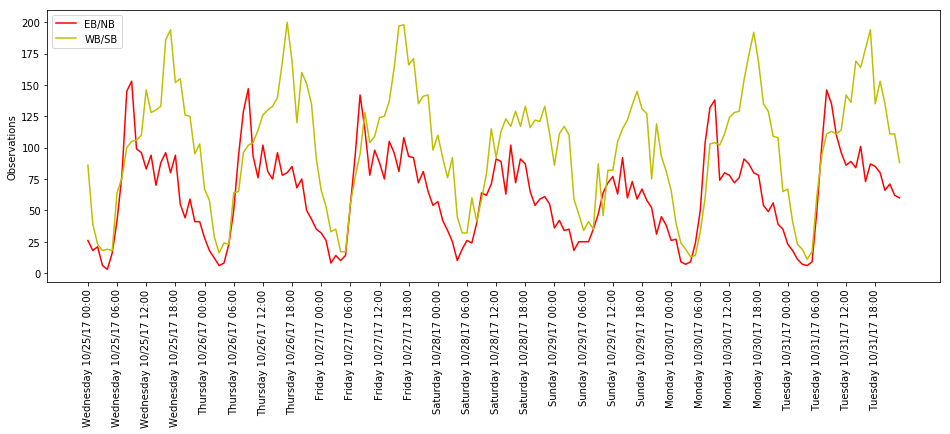

DT-0116. University-NB_King-to-Queen / DT-0111. University-SB_Queen-to-King


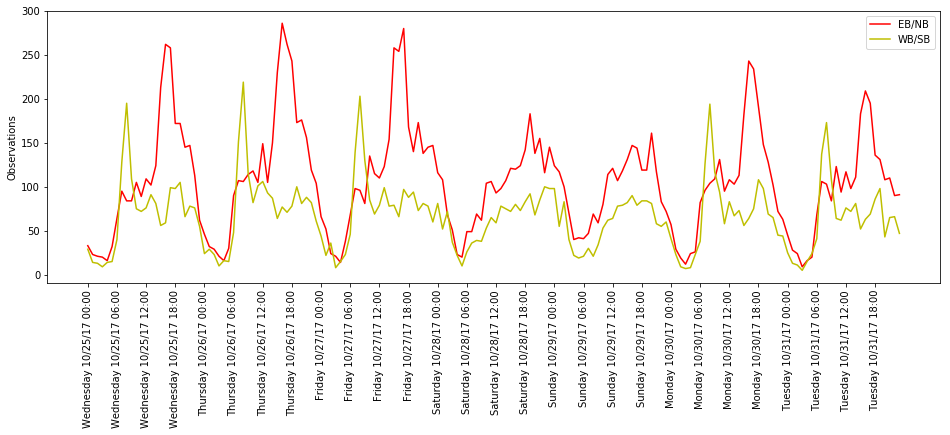

DT-0070. Front-EB_Bathurst-to-Spadina / DT-0078. Front-WB_Spadina-to-Bathurst


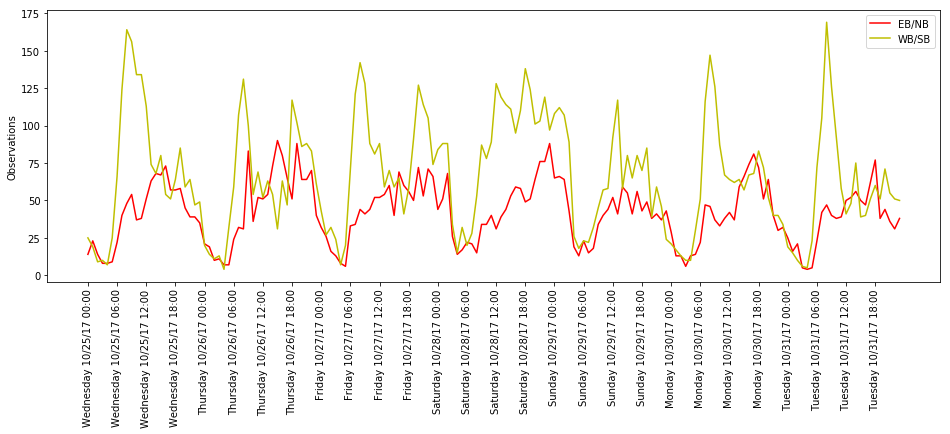

DT-0072. Front-EB_University-to-Yonge / DT-0076. Front-WB_Yonge-to-University


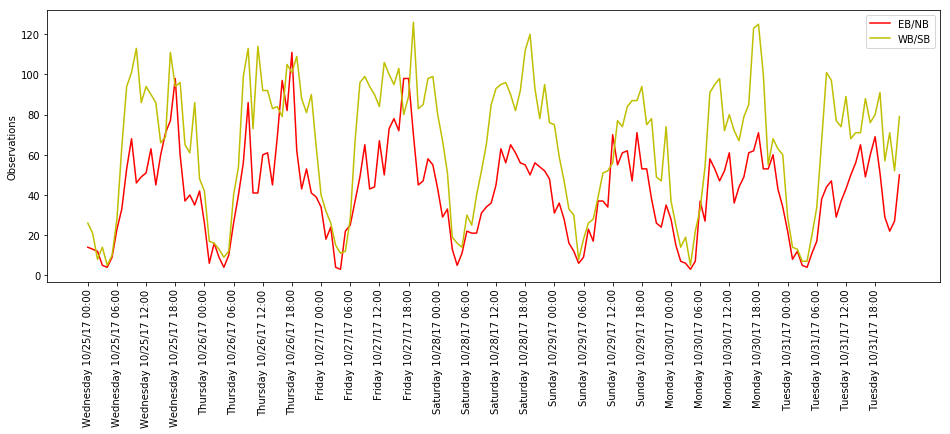

DT-0001.College-EB_Bathurst-to-University / DT-0004. College-WB_University-to-Bathurst


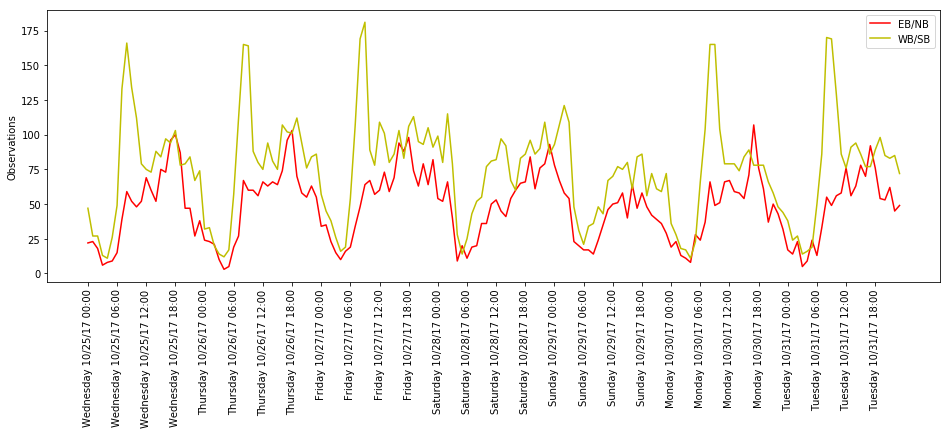

DT-0055. King-EB_Yonge-to-Jarvis / DT-0060. King-WB_Jarvis-to-Yonge


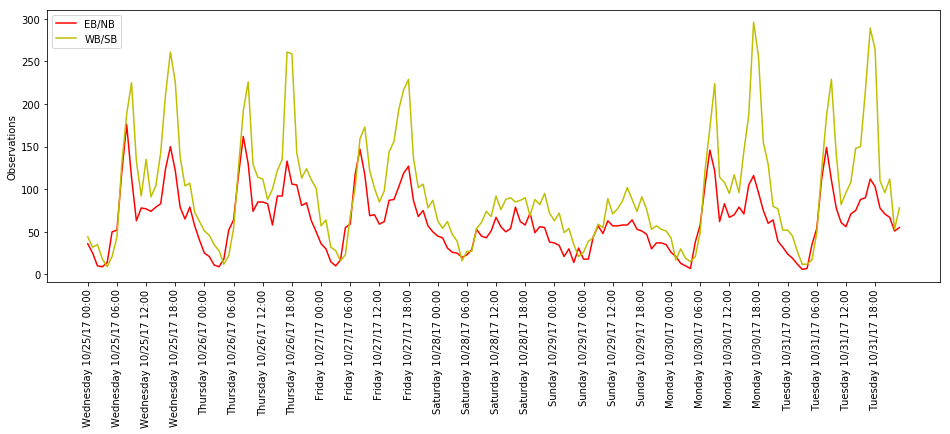

DT-0022. Queen-EB_Bathurst-to-Spadina / DT-0033. Queen-WB_Spadina-to-Bathurst


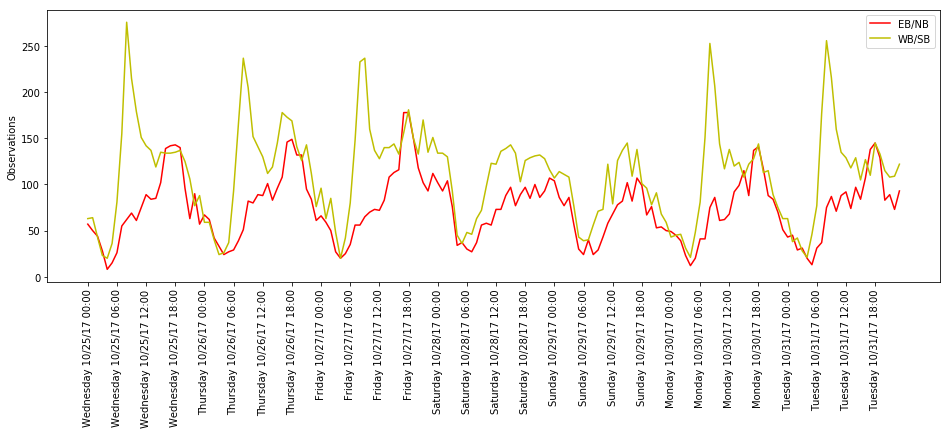

DT-0057. King-EB_Parliament-to-Broadview / DT-0058. King-WB_Broadview-to-Parliament


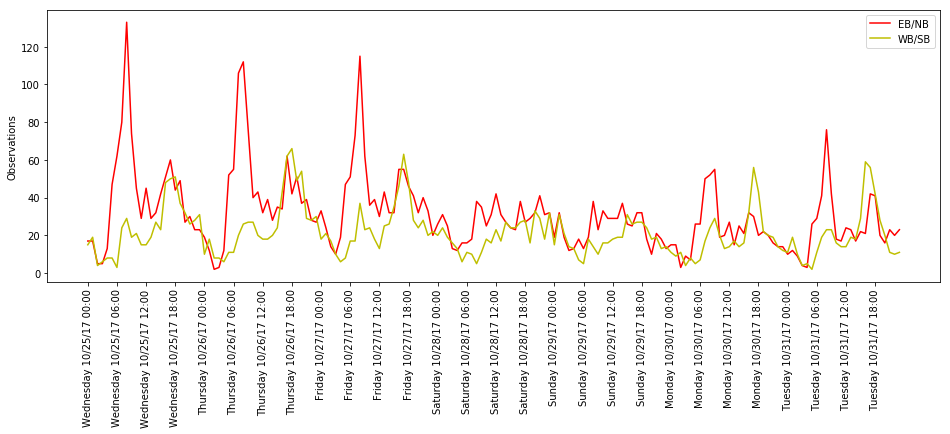

DT-0106. Spadina-NB_Front-to-King / DT-0103. Spadina-SB_King-to-Front


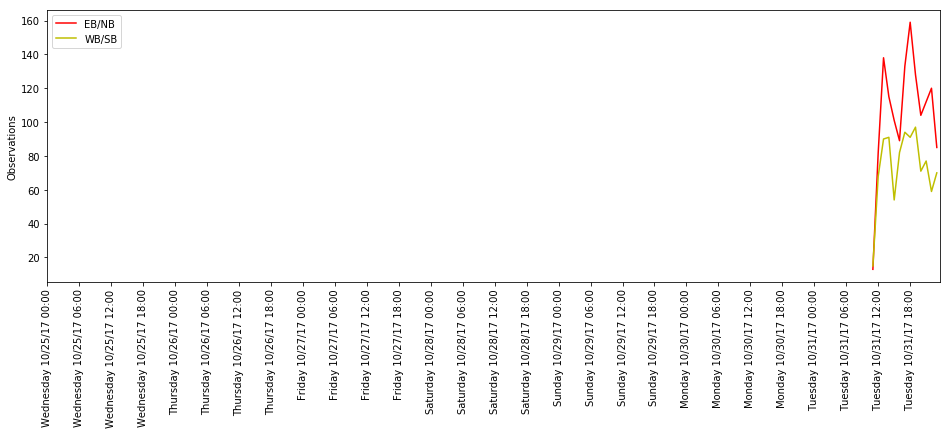

DT-0051. King-EB_Strachan-to-Bathurst / DT-0064. King-WB_Bathurst-to-Strachan


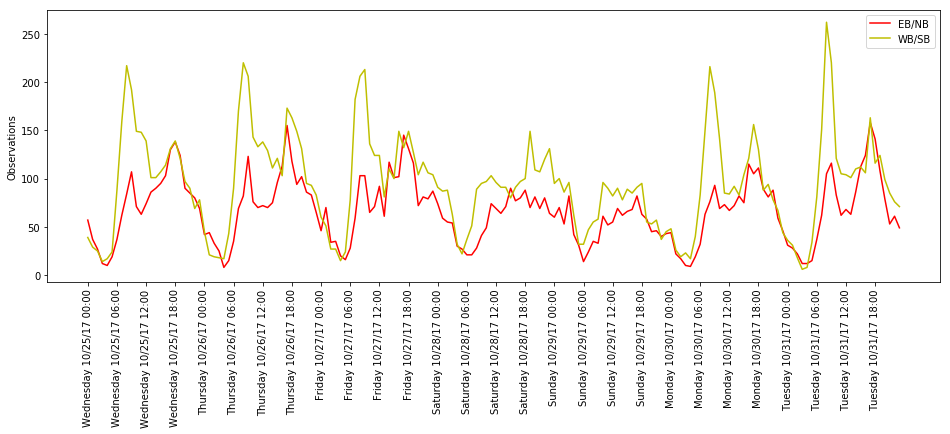

DT-0027. Queen-EB_Parliament-to-Broadview / DT-0028. Queen-WB_Broadview-to-Parliament


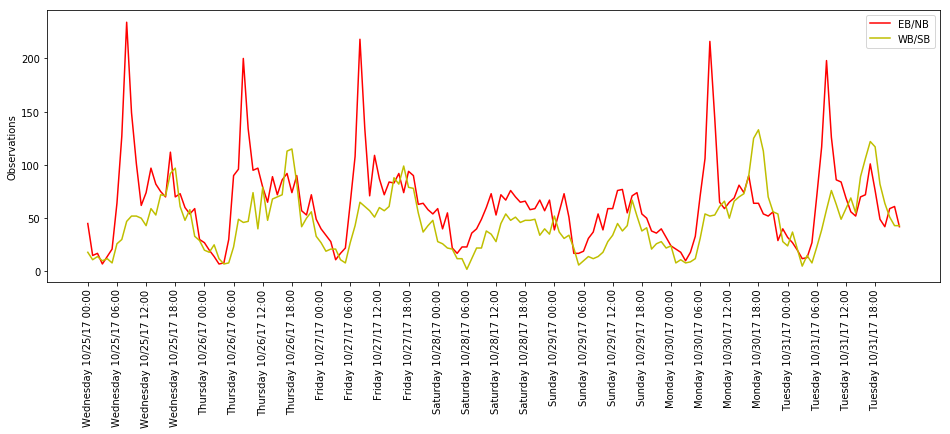

DT-0105. Spadina-NB_Bremner-to-Front / DT-0104. Spadina-SB_Front-to-Bremner


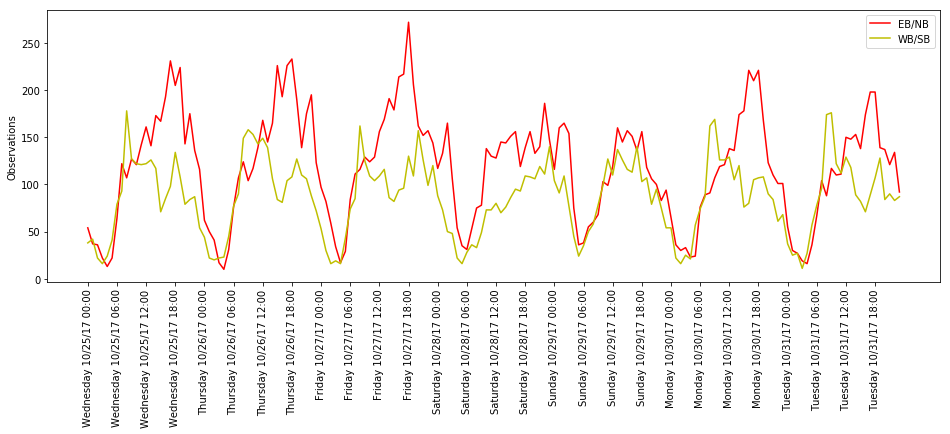

DT-0049. King-EB_Roncesvalles-to-Dufferin / DT-0066. King-WB_Dufferin-to-Roncesvalles


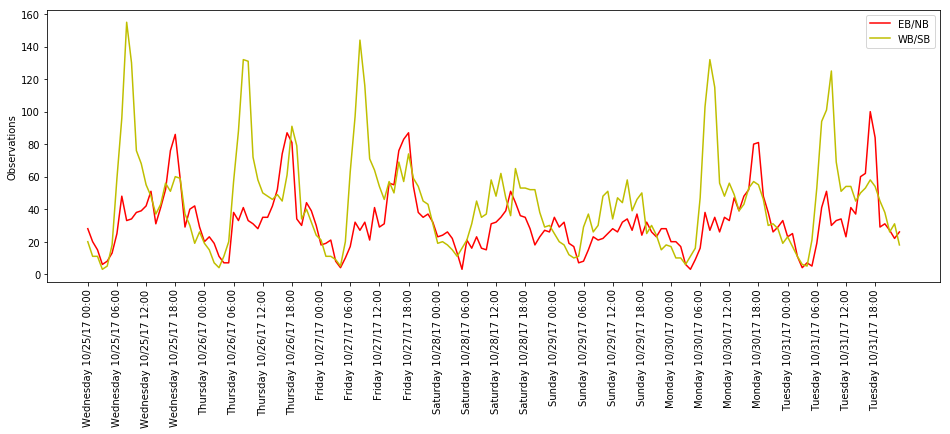

DT-0096. Bathurst-NB_FortYork-to-Front / DT-0095. Bathurst-SB_Front-to-FortYork


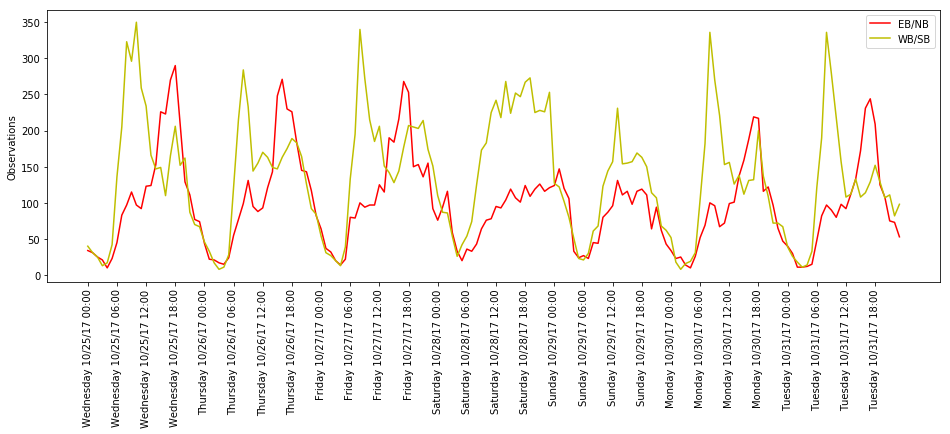

DT-0019. Queen-EB_Roncesvalles-to-Dufferin / DT-0036. Queen-WB_Dufferin-to-Roncesvalles


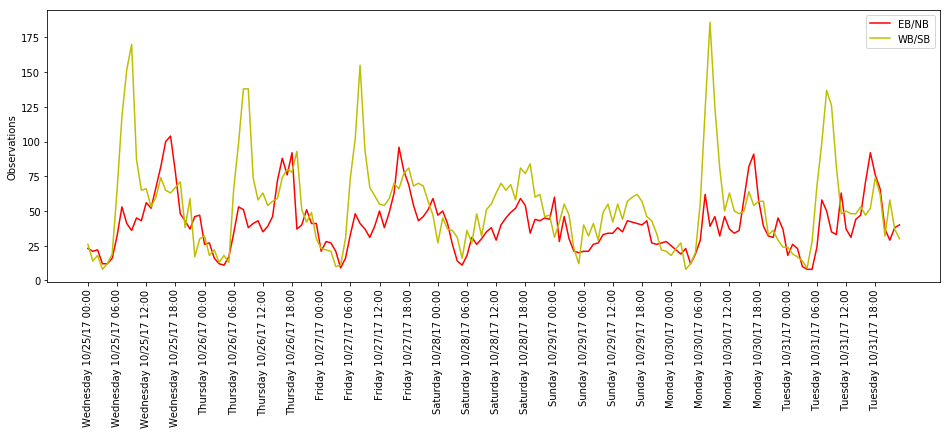

DT-0098. Bathurst-NB_King-to-Queen / DT-0093. Bathurst-SB_Queen-to-King


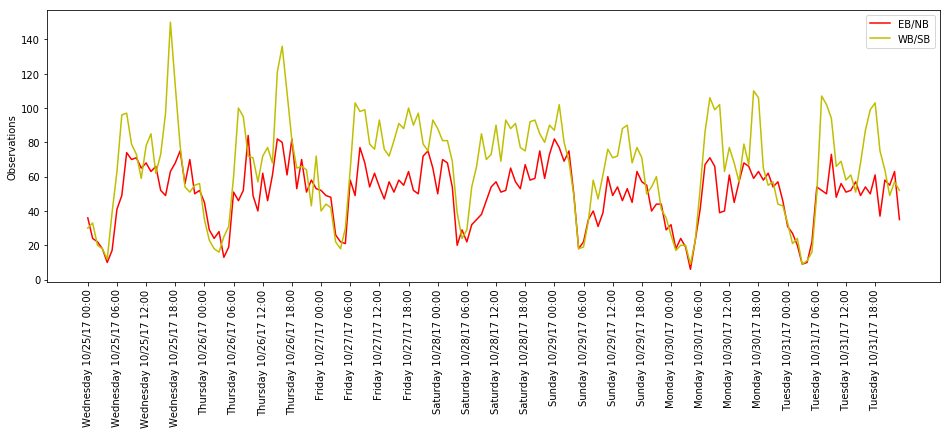

DT-0130. Jarvis-NB_Queen-to-Dundas / DT-0125. Jarvis-SB_Dundas-to-Queen


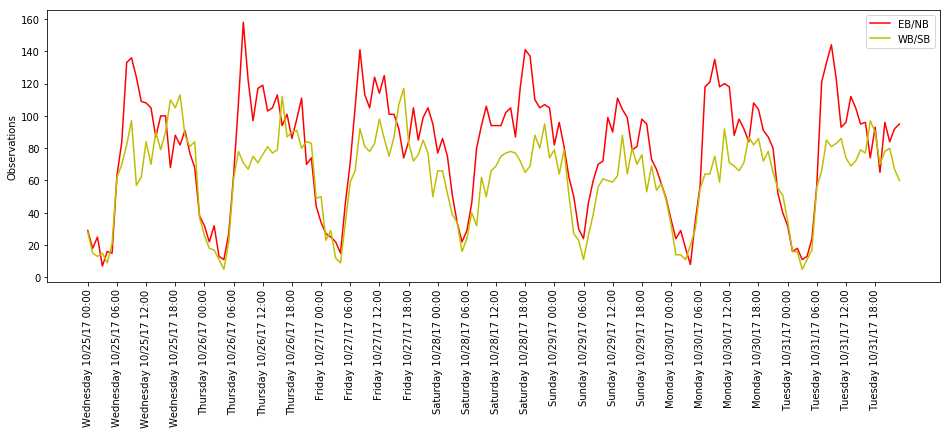

DT-0122. Yonge-NB_Front-to-King / DT-0121. Yonge-SB_King-to-Front


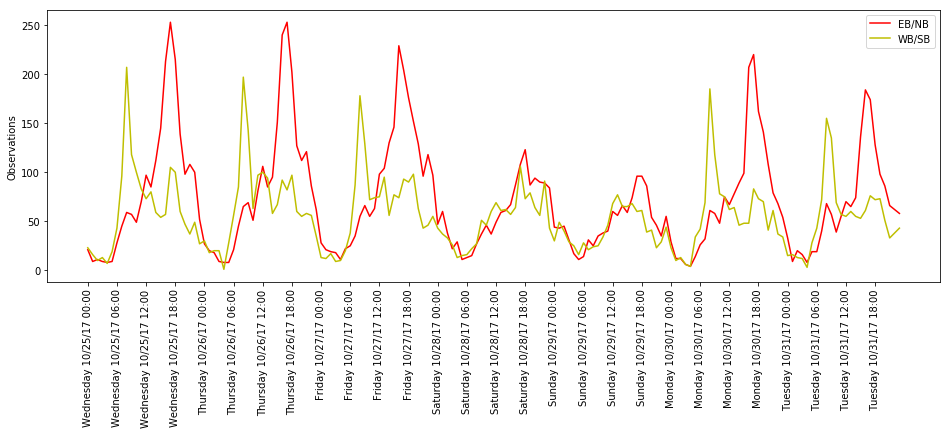

DT-0115. University-NB_Front-to-King / DT-0112. University-SB_King-to-Front


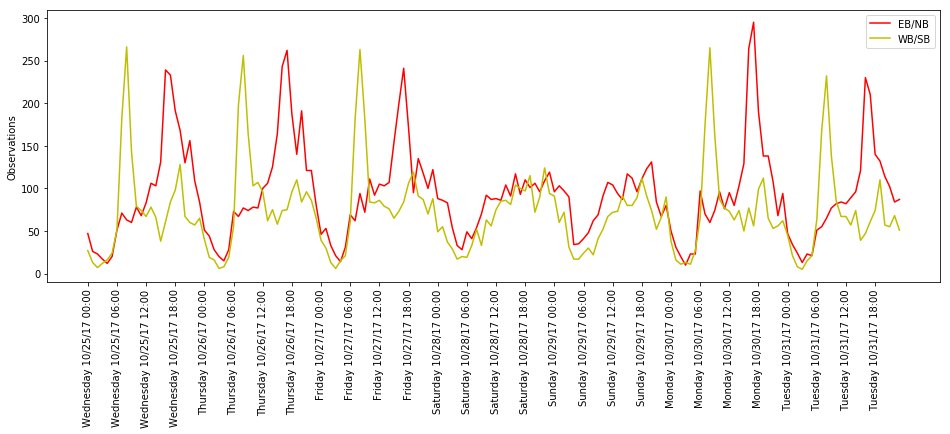

DT-0088. Dufferin-NB_Queen-to-Dundas / DT-0085. Dufferin-SB_Dundas-to-Queen


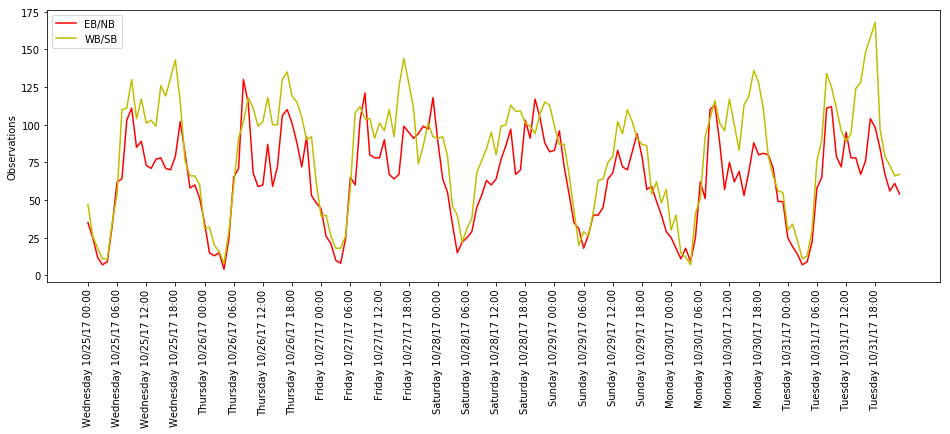

DT-0099. Bathurst-NB_Queen-to-Dundas / DT-0092. Bathurst-SB_Dundas-to-Queen


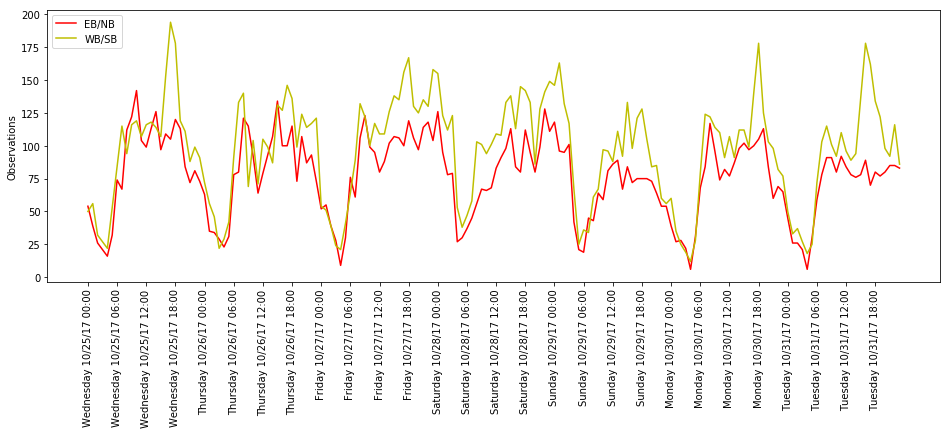

DT-0129. Jarvis-NB_King-to-Queen / DT-0126. Jarvis-SB_Queen-to-King


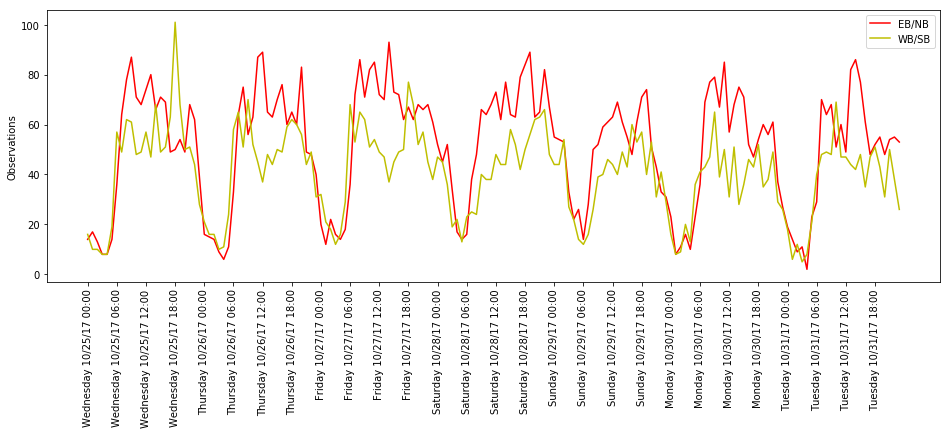

DT-0005. Dundas-EB_Roncesvalles-to-Dufferin / DT-0018. Dundas-WB_Dufferin-to-Roncesvalles


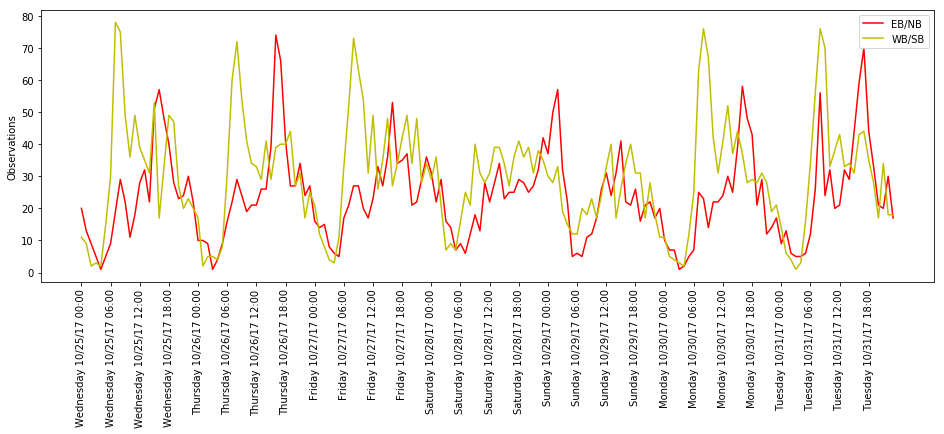

DT-0026. Queen-EB_Jarvis-to-Parliament / DT-0029. Queen-WB_Parliament-to-Jarvis


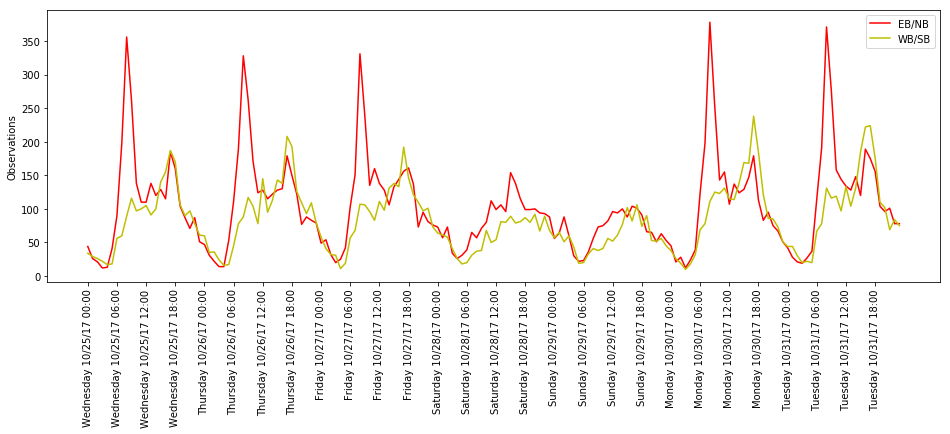

DT-0090. Strachan-NB_King-to-Queen / DT-0089. Strachan-SB_Queen-to-King


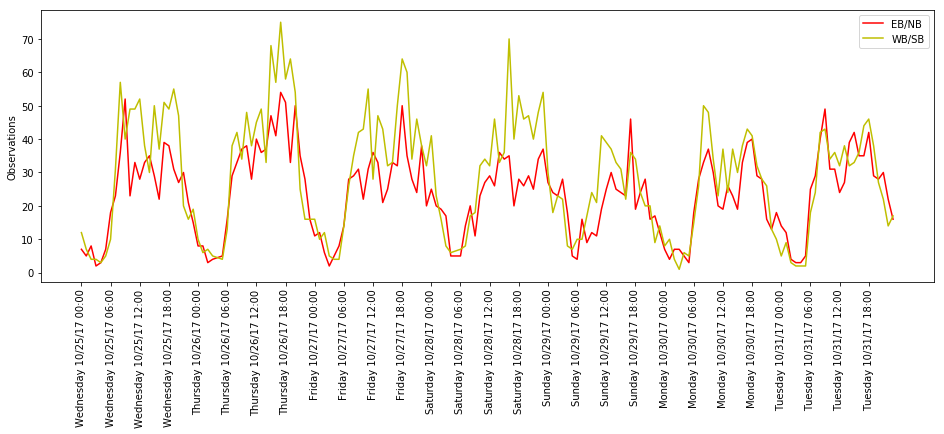

DT-0100. Bathurst-NB_Dundas-to-College / DT-0091. Bathurst-SB_College-to-Dundas


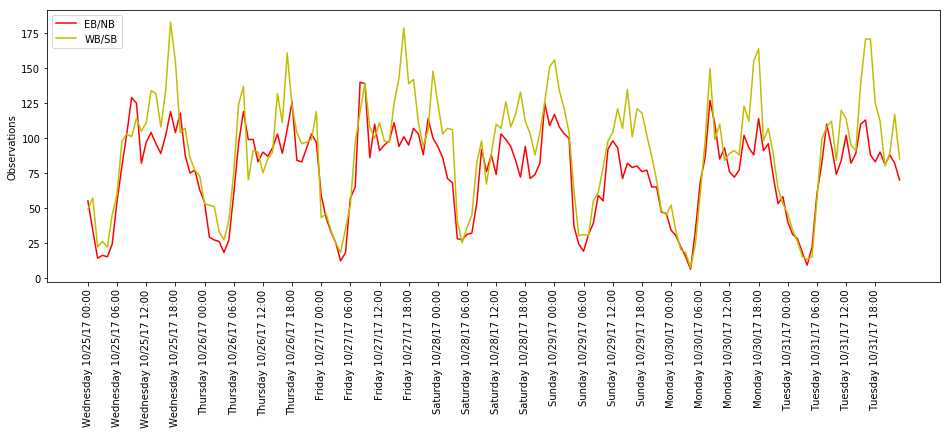

DT-0097. Bathurst-NB_Front-to-King / DT-0094. Bathurst-SB_King-to-Front


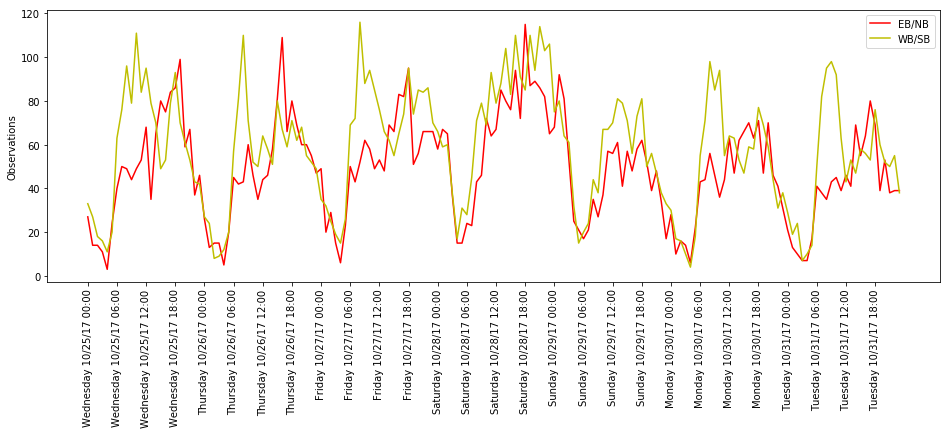

DT-0080. FortYork/Bremner-EB_Spadina-to-York / DT-0081. FortYork/Bremner-WB_York-to-Spadina


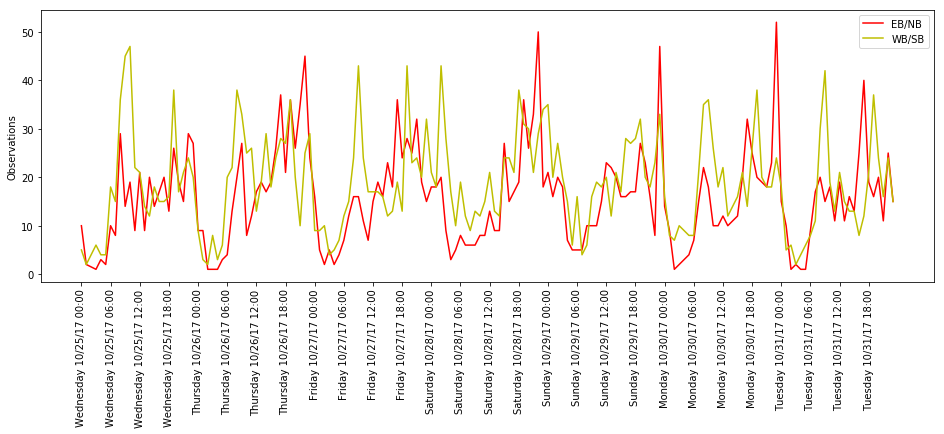

DT-0084. Roncesvalles-NB_Queen-to-Dundas / DT-0083. Roncesvalles-SB_Dundas-to-Queen


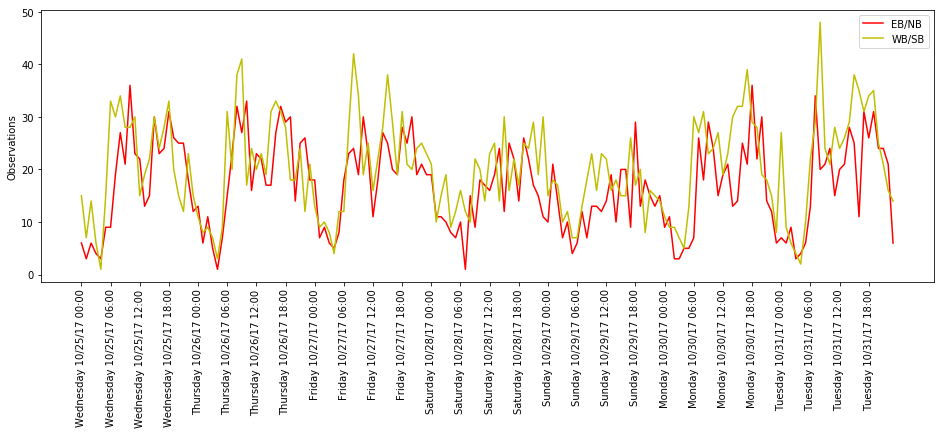

DT-0123. Yonge-NB_King-to-Queen / DT-0120. Yonge-SB_Queen-to-King


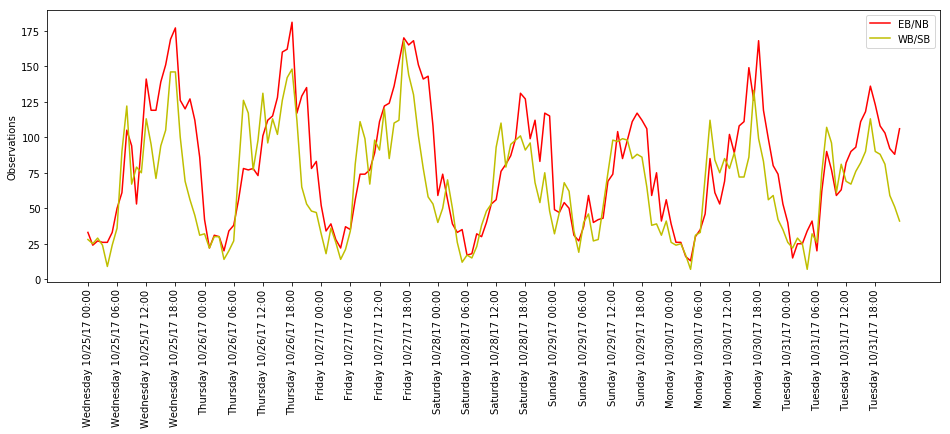

DT-0108. Spadina-NB_Queen-to-Dundas / DT-0101. Spadina-SB_Dundas-to-Queen


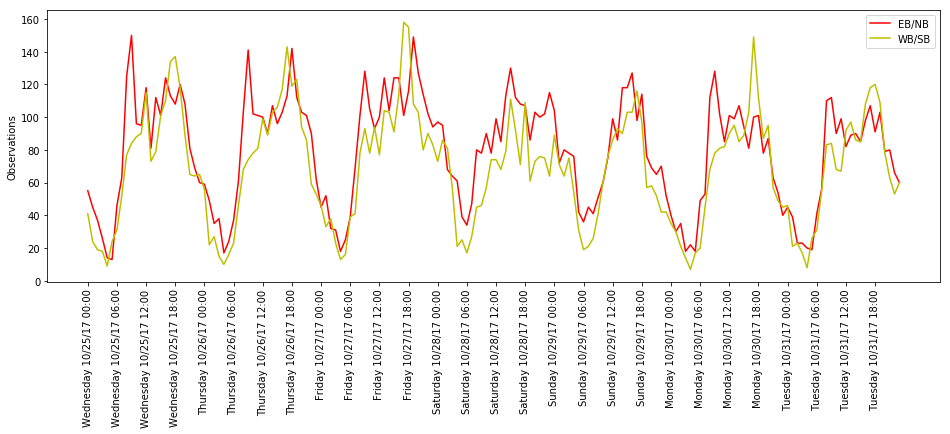

DT-0021. Queen-EB_Strachan-to-Bathurst / DT-0034. Queen-WB_Bathurst-to-Strachan


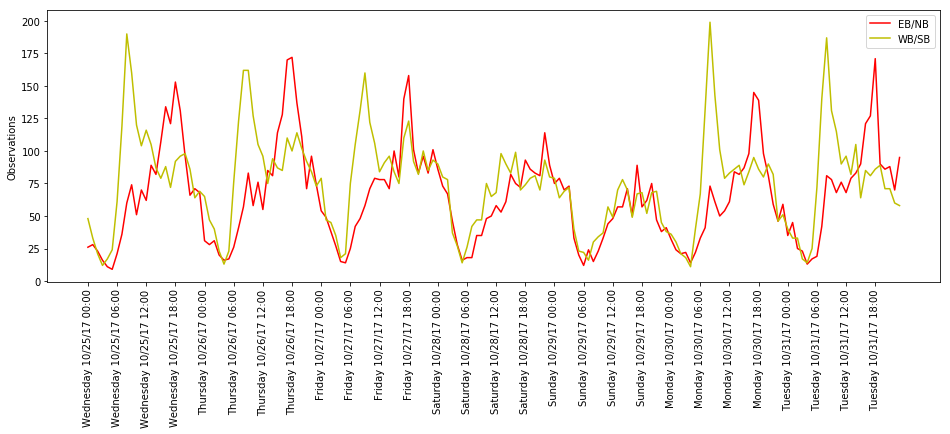

DT-0020. Queen-EB_Dufferin-to-Strachan / DT-0035. Queen-WB_Strachan-to-Dufferin


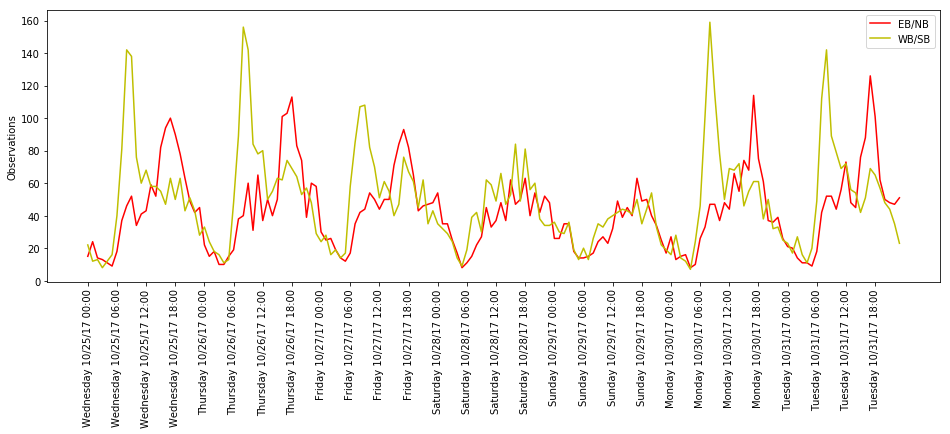

DT-0087. Dufferin-NB_King-to-Queen / DT-0086. Dufferin-SB_Queen-to-King


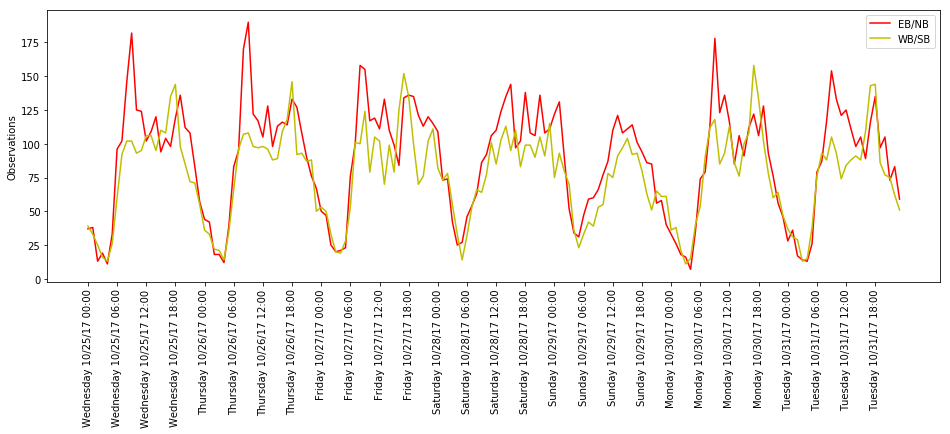

DT-0024. Queen-EB_University-to-Yonge / DT-0031. Queen-WB_Yonge-to-University


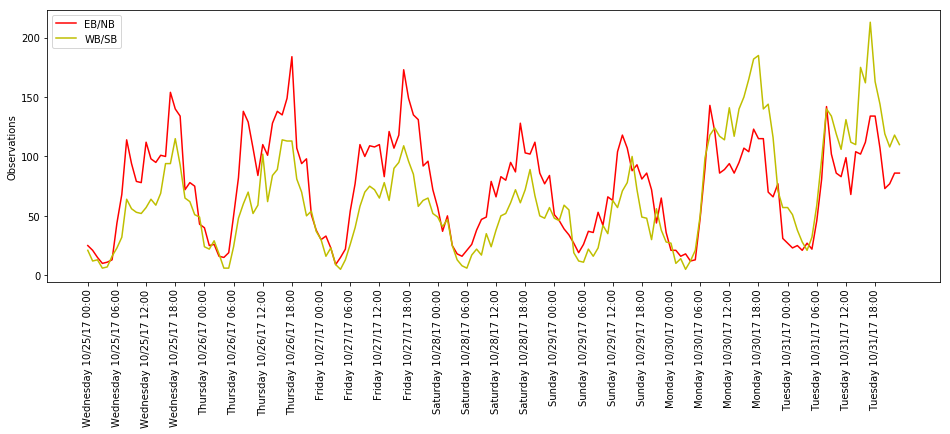

DT-0140. Broadview-NB_Eastern-to-Queen / DT-0139. Broadview-SB_Queen-to-Eastern


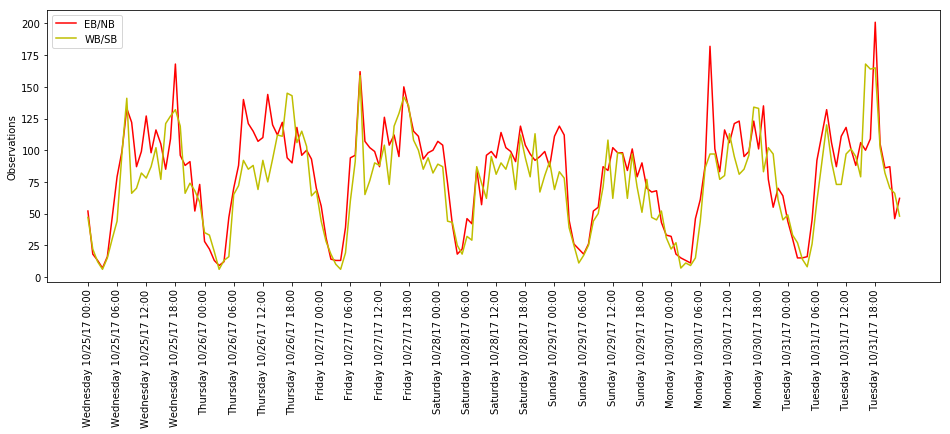

DT-0136. Parliament-NB_King-to-Queen / DT-0133. Parliament-SB_Queen-to-King


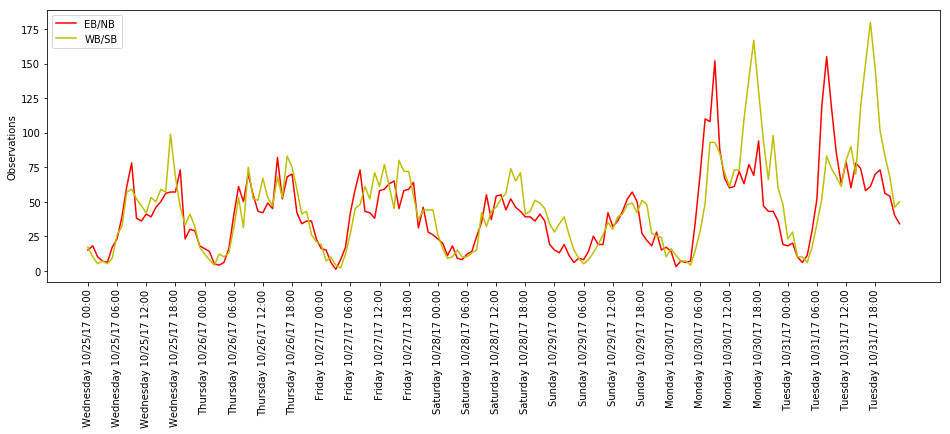

DT-0135. Parliament-NB_Front-to-King / DT-0134. Parliament-SB_King-to-Front


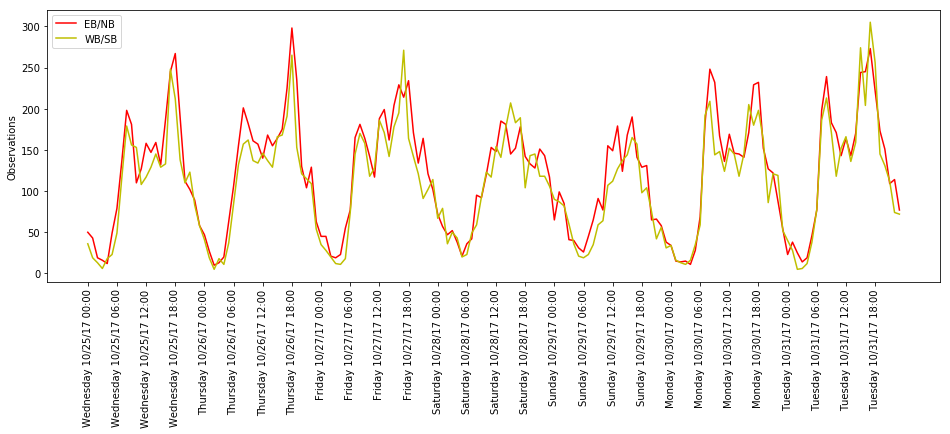

DT-0025. Queen-EB_Yonge-to-Jarvis / DT-0030. Queen-WB_Jarvis-to-Yonge


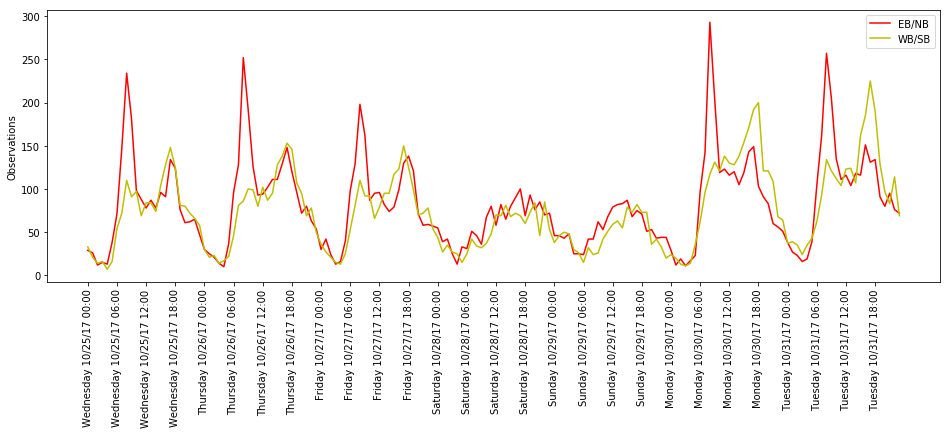

DT-0138. Parliament-NB_Dundas-to-College / DT-0131. Parliament-SB_College-to-Dundas


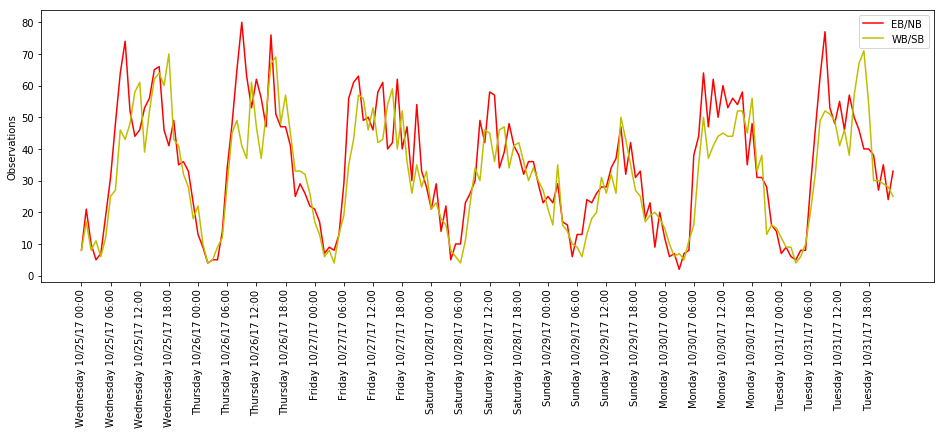

DT-0079. FortYork/Bremner-EB_Bathurst-to-Spadina / DT-0082. FortYork/Bremner-WB_Spadina-to-Bathurst


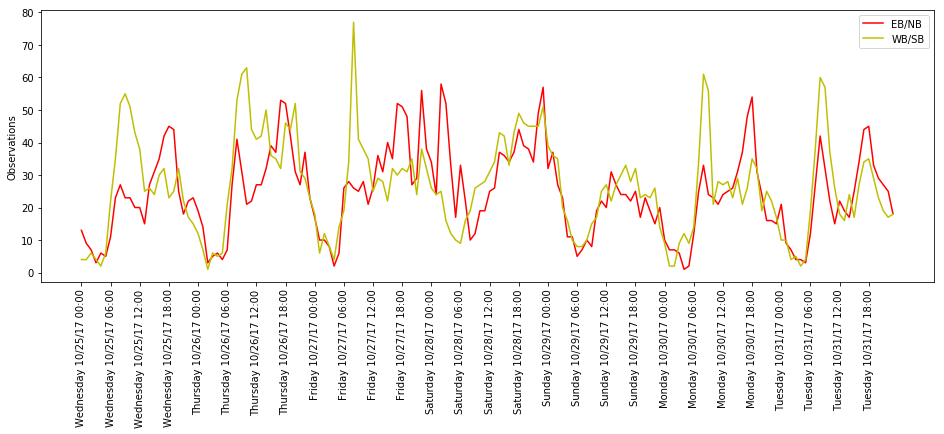

DT-0124. Yonge-NB_Queen-to-Dundas / DT-0119. Yonge-SB_Dundas-to-Queen


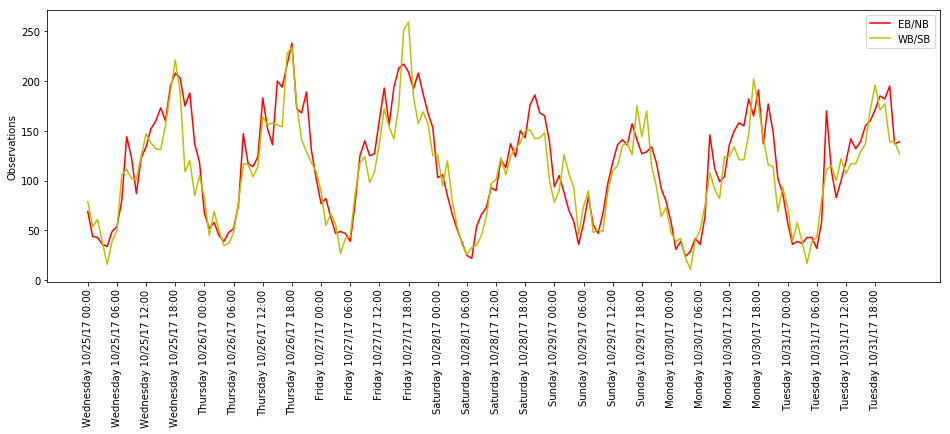

DT-0137. Parliament-NB_Queen-to-Dundas / DT-0132. Parliament-SB_Dundas-to-Queen


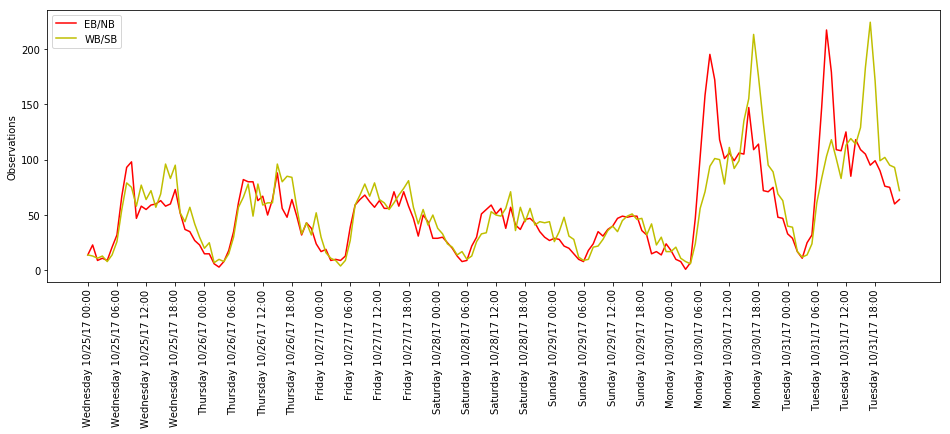

DT-0056. King-EB_Jarvis-to-Parliament / DT-0059. King-WB_Parliament-to-Jarvis


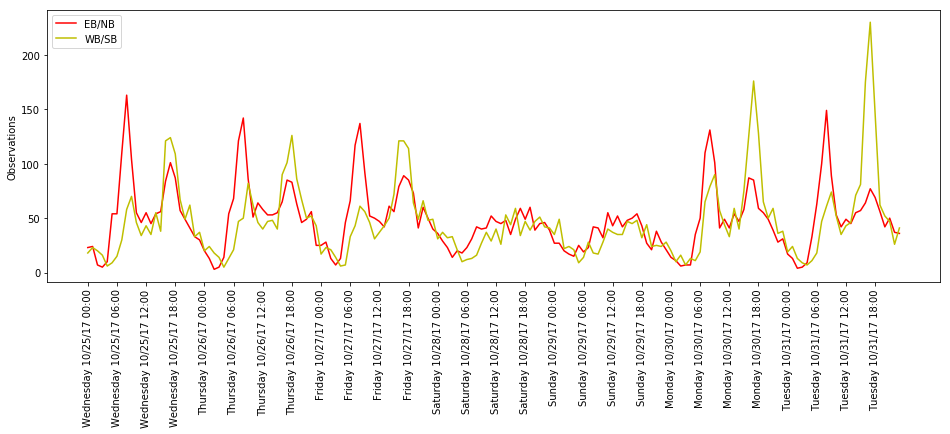

DT-0050. King-EB_Dufferin-to-Strachan / DT-0065. King-WB_Strachan-to-Dufferin


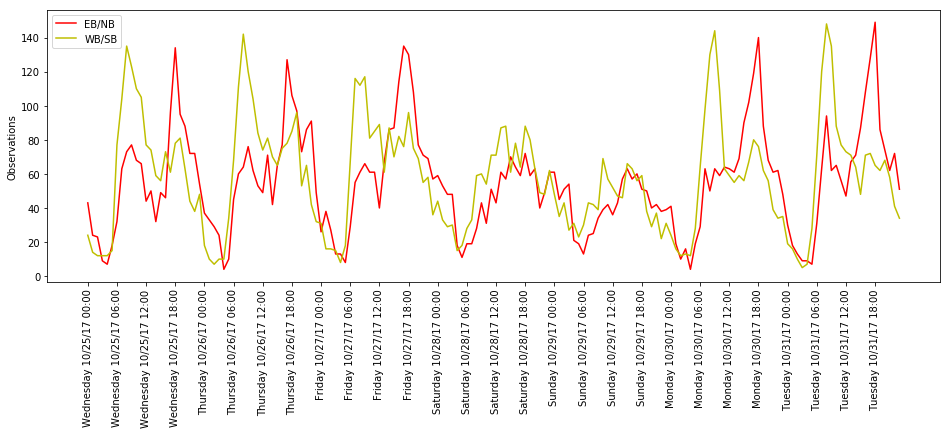

DT-0074. Front-EB_Jarvis-to-Parliament / DT-0075. Front-WB_Parliament-to-Jarvis


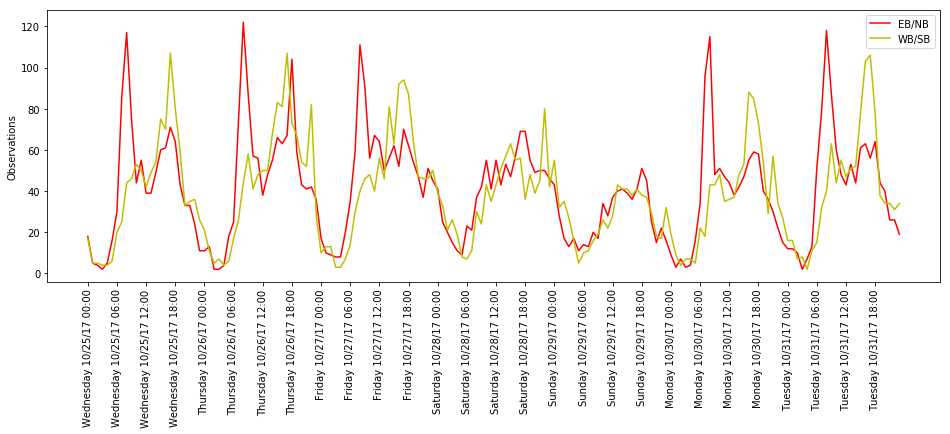

DT-0114. York-NB_Bremner-to-Front / DT-0113. York-SB_Front-to-Bremner


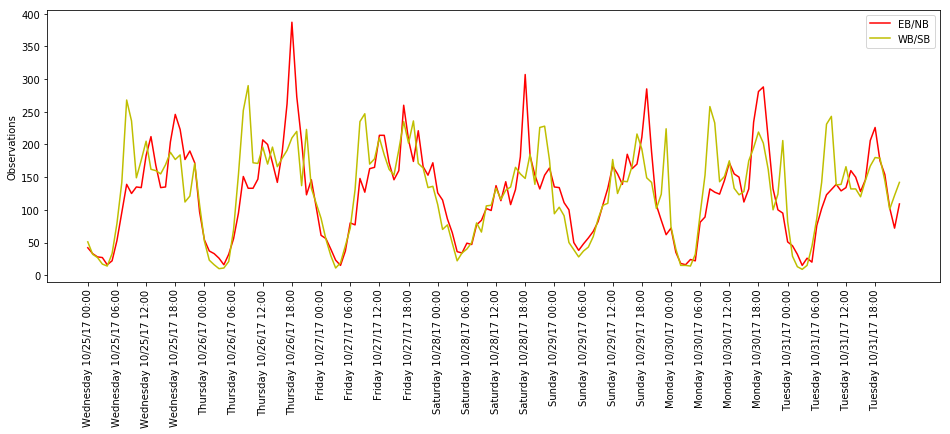

DT-0128. Jarvis-NB_Front-to-King / DT-0127. Jarvis-SB_King-to-Front


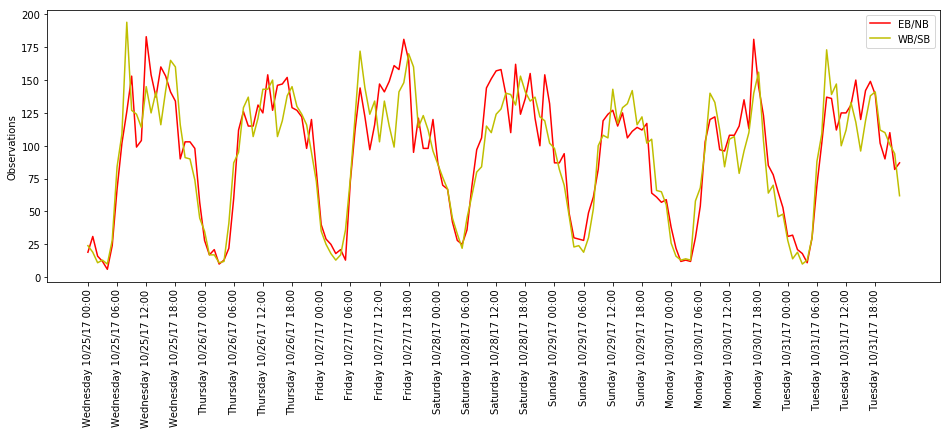

DT-0023. Queen-EB_Spadina-to-University / DT-0032. Queen-WB_University-to-Spadina


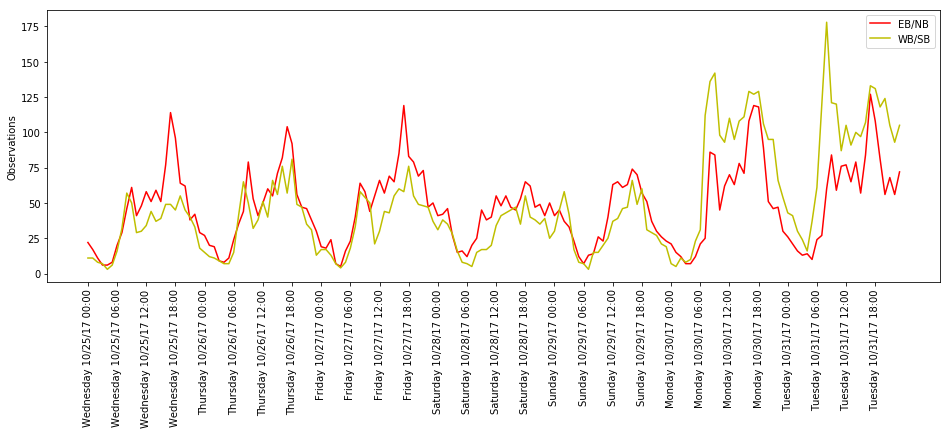

DT-0107. Spadina-NB_King-to-Queen / DT-0102. Spadina-SB_Queen-to-King


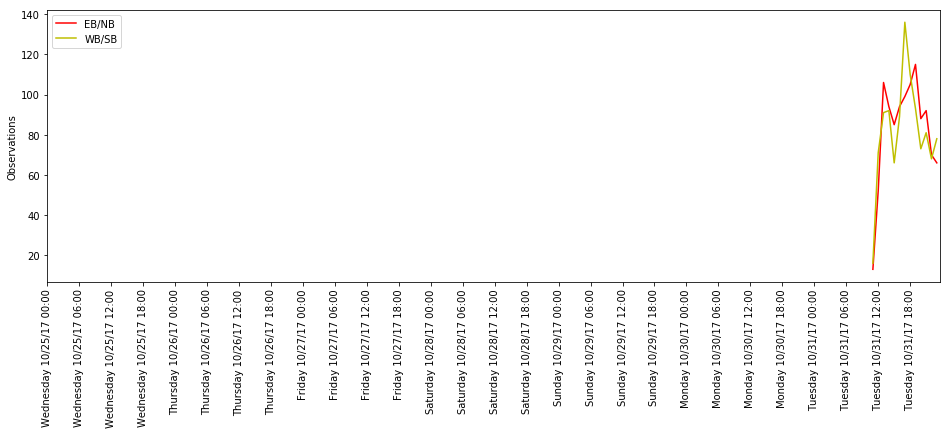

In [89]:
for i in range(len(routes)):
    print(ebnb_route[i] + " / " + wbsb_route[i])
    sql = pg.SQL('''CREATE OR REPLACE TEMP VIEW wbsb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {ebnb_route} \
                    AND datetime_bin < '2017-11-01' AND datetime_bin >= '2017-10-25' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    CREATE OR REPLACE TEMP VIEW ebnb AS \
                    SELECT DATE_TRUNC('hour', datetime_bin) datetime_bin, SUM(obs) obs \
                    FROM aggr_5min_bt \
                    WHERE report_name = {wbsb_route} \
                    AND datetime_bin < '2017-11-01' AND datetime_bin >= '2017-10-25' \
                    GROUP BY report_name, DATE_TRUNC('hour', datetime_bin); \
                    SELECT wbsb.datetime_bin datetime_bin, wbsb.obs wbsb_obs, ebnb.obs ebnb_obs
                    FROM wbsb \
                    INNER JOIN ebnb ON wbsb.datetime_bin = ebnb.datetime_bin \
                    ORDER BY datetime_bin;
        ''').format(ebnb_route = pg.Literal(ebnb_route[i]), wbsb_route = pg.Literal(wbsb_route[i]))
    route_obs = pandasql.read_sql(sql, con)
    fig, ax = plt.subplots(1, 1, figsize=(16,5))
    ebnb_line = ax.plot(route_obs.datetime_bin, route_obs.ebnb_obs, color='r')
    wbsb_line = ax.plot(route_obs.datetime_bin, route_obs.wbsb_obs, color='y')
    ax.set_ylabel('Observations')
    start = datetime.strptime('2017-10-25 00:00:00', '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime('2017-11-01 00:00:00', '%Y-%m-%d %H:%M:%S')
    time = []
    
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    for i in (start + timedelta(n) for n in np.arange(0,7, 0.25)):
        time.append(i.strftime("%A %x %H:%M"))
    ax.set_xticklabels(time, rotation=90)
    ax.set_xticks(time)
    ax.legend((ebnb_line[0], wbsb_line[0]), ('EB/NB', 'WB/SB'))
    plt.show()

Majority of the routes show non-matching EB/NB and WB/SB observations where one direction would have a significantly higher number of observations than the other. Extreme cases such as 'Front - Spadina to University' and 'University - Queen to Dundas' show results where observations are consistently higher for one direction. For 'University - Queen to Dundas' the SB direction observations briefly surpasses the NB direction observations during the AM peak periods. This is then met with a  number of NB direction observations almost doubles the opposing observations during the PM peak period. This may show a bias towards the stopped traffic of the NB side in terms of number of observations while only a fraction of the actual number of observations for the SB side is taken. A similar graph with the the same results but in reverse is demonstrated by 'Dundas - Spadina to University'.